# Monolithic Explainability Comparison

In [56]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [57]:
# imports
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import time
import os
# import data class
from utilities.dataset_utils import DiabetesData

# loading qml models
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.algorithms import VQC

# loading classical models
from joblib import load

# explainability imports
from shap import KernelExplainer
from shap import summary_plot

# simulator
from qiskit_aer import AerSimulator
from qiskit_aer.primitives import SamplerV2 as Sampler

In [58]:
np.random.seed(42)

In [59]:
# path to diabetes.csv
path = os.path.join(os.getcwd(), '..', 'utilities', 'diabetes.csv')
# load dataset class
dataset = DiabetesData(path)

In [60]:
# list of feature names
feature_names = [
    "Pregnancies",
    "Glucose",
    "BloodPressure",
    "SkinThickness",
    "Insulin",
    "BMI",
    "DiabetesPedigreeFunction",
    "Age"
]

In [61]:
# get data
X_train, X_test, y_train, y_test = dataset.preprocess_data_ranged()

In [62]:
# setup backend simulator
backend = AerSimulator()
backend.set_options(max_parallel_threads=os.cpu_count(), method='statevector')

In [63]:
# sampler
sampler = Sampler.from_backend(backend)

In [64]:
path = os.path.join(os.getcwd(), '..', 'models', 'qml-simulator', 'qsvc_best_params.model')
qsvc = QSVC.load(path)

In [65]:
path = os.path.join(os.getcwd(), '..', 'models', 'qml-simulator', 'vqc_best_params.model')
vqc = VQC.load(path)

In [66]:
path = os.path.join(os.getcwd(), '..', 'models', 'ml', 'svc.joblib')
svc = load(path)

In [67]:
path = os.path.join(os.getcwd(), '..', 'models', 'ml', 'random_forest.joblib')
rf = load(path)

In [68]:
test_features = X_test[:50]

In [69]:
def vqc_wrapper(test_features):
    """
    Wrapper function for VQC model to be used with SHAP.
    """
    # predict using VQC model
    y_pred = vqc.predict(test_features)
    
    return np.array(y_pred).reshape(-1, 1)

In [ ]:
def qsvc_wrapper(test_features):
    """
    Wrapper function for QSVC model to be used with SHAP.
    """
    # batch processing for qsvc.predict
    y_preds = []
    for i in range(0, len(test_features), 10):
        # predict using QSVC model
        y_pred = qsvc.predict(test_features[i:i+10])
        y_preds.append(y_pred)
    # concatenate predictions
    y_pred = np.concatenate(y_preds, axis=0)
    # reshape predictions
    y_pred = y_pred.reshape(-1, 1)
    
    return y_pred

In [ ]:
vqc_explainer = KernelExplainer(vqc_wrapper, test_features)
vqc_shap = vqc_explainer.shap_values(test_features)
summary_plot(vqc_shap, test_features, feature_names=feature_names, show=False)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

/tmp/ipykernel_1761683/204769558.py:3: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_plot(svc_shap, test_features, feature_names=feature_names, show=False)


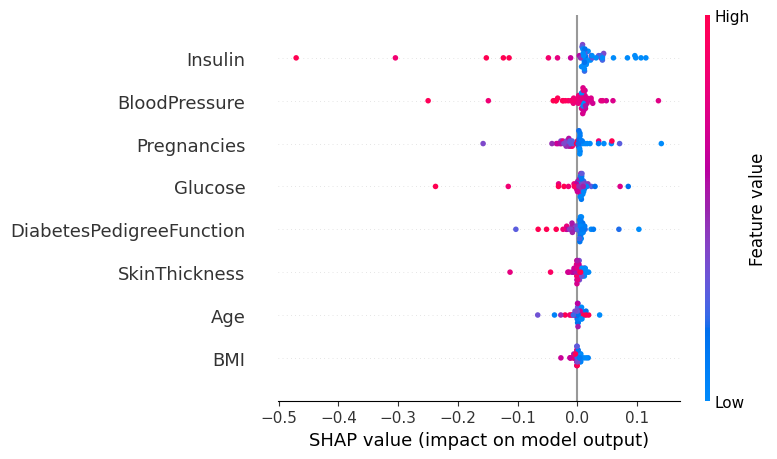

In [ ]:
svc_explainer = KernelExplainer(svc.predict, test_features)
svc_shap = svc_explainer.shap_values(test_features)
summary_plot(svc_shap, test_features, feature_names=feature_names, show=False)